# Appendix: Numerical Optimization

This notebook uses the *Optim* package which has general-purpose optimization routines.

## Load Packages

In [1]:
using Optim
using Dates

include("printmat.jl")

printlnPs (generic function with 2 methods)

In [3]:
using Plots
backend = "gr"              #"gr" (default), "pyplot" 

if backend == "pyplot"
    pyplot(size=(600,400))
else    
    gr(size=(600,400))
    default(fmt = :png)
end

# Unconstrained Optimization

In the example below, we want to choose $(x,y)$ so as to minimize the fairly simple objective function

$
(x-2)^2 + (4y+3)^2,  
$

without any constraints. (Yes, the solution should be $(x,y)=(2,-3/4)$.)


In the next few cells, we 

(1) define the loss function and calculate its value on a grid of (x,y) values

(2) plot the contours of the loss function (and then also the surface)

(3) do a numerical minimization to find the optimal values

In [4]:
function lossfun(p::Vector)
    (x,y) = (p[1],p[2])          #unpack the choice variables
     L    = (x-2)^2 + (4*y+3)^2
    return L
end

lossfun (generic function with 1 method)

In [5]:
nx = 2*41
ny = 2*61
x = range(1,stop=5,length=nx)    
y = range(-1,stop=0,length=ny)

loss2d = fill(NaN,(nx,ny))      #matrix with loss fn values
for i = 1:nx, j = 1:ny                   
    loss2d[i,j] = lossfun([x[i];y[j]])
end

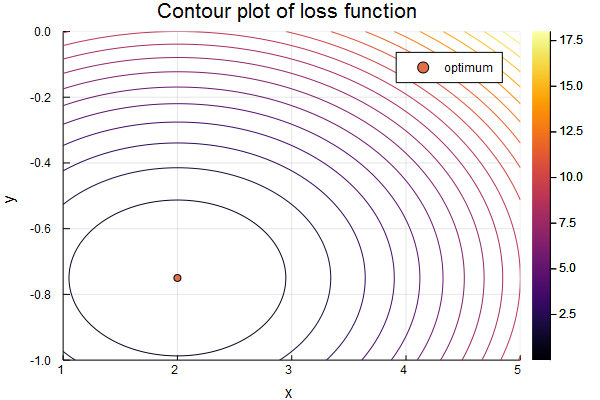

In [6]:
p1 = contour(x,y,copy(loss2d'),xlims=(1,5),ylims=(-1,0),legend=true,levels=21)  #notice: copy(loss2d')
scatter!(p1,[2],[-0.75],label="optimum")
title!(p1,"Contour plot of loss function")
xlabel!(p1,"x")
ylabel!(p1,"y")
display("image/png",p1)

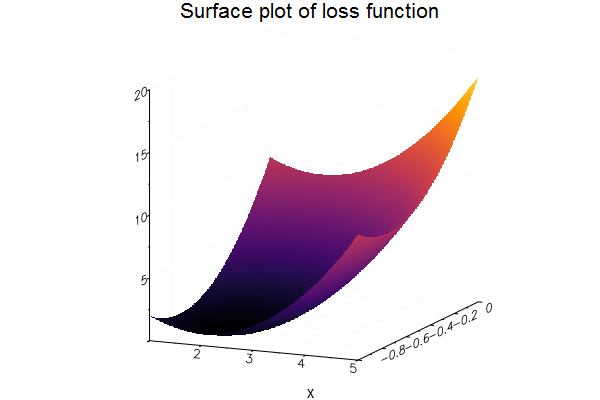

In [7]:
p1 = surface(x,y,copy(loss2d'),legend=false)   
title!(p1,"Surface plot of loss function")
xlabel!(p1,"x")
display("image/png",p1)

In [8]:
Sol = optimize(p->lossfun(p),[0.0;0.0])

printlnPs("minimum at (x,y)= ",Optim.minimizer(Sol))

minimum at (x,y)=      2.000    -0.750


# Optimization with Equality Constraints

We now impose the constraint that 

$
x+2y-2.5=0.
$

This clearly means that $x=2.5-2y$. In this simple case, we could rewrite the optimization problem in terms of $y$ only. However, this might be tricky with other types of constraints, so we instead illustrate a more general apporach.

We do this by adding a penalty term $\lambda(x+2y-2.5)^2$ to the loss function. 


In the next few cells, we 

1. Plot the loss function together with the constraint
    
2. redefine the loss function to also include a penalty for violating the constraint

3. solve for and and plot the optimal values as we impose a higher and higher penalty ($\lambda$) on violating the constraint, starting from $\lambda=0$ and then using the solution as the starting guess for the next iteration.

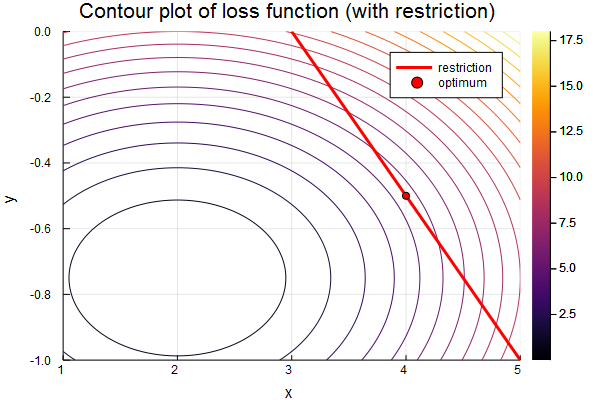

In [9]:
p1 = contour(x,y,copy(loss2d'),xlims=(1,5),ylims=(-1,0),legend=true,levels=21) 
plot!(p1,3 .- 2*y,y,color=:red,linewidth=3,label="restriction")
scatter!(p1,[4],[-0.5],color=:red,label="optimum")
title!(p1,"Contour plot of loss function (with restriction)")
xlabel!(p1,"x")
ylabel!(p1,"y")
display("image/png",p1)

In [10]:
function lossfun2(p::Vector,lambda)
    (x,y) = (p[1],p[2])          #unpack the choice variables    
    L1 = lossfun([x;y])
    c  = x + 2*y - 3             #equality restriction
    L  = L1 + lambda*c^2
  return L
end

lossfun2 (generic function with 1 method)

In [11]:
println("\nRestricted minima from harder and harder punishment of the constraint violation")
println("iteration,    lambda,  x + 2.5*y - 3,  x,    y")
Δpar = Inf
par0 = [2.5;0.0]                  #initial guess obeys restriction
parM = fill(NaN,(500,2))
i = 1
while maximum(abs.(Δpar)) > 1e-4
    global Δpar, i, par0
    local λ, Sol, par1, x, y, c
    λ    = (i-1)*2
    Sol  = optimize(par->lossfun2(par,λ),par0)
    par1 = Optim.minimizer(Sol)
    (x,y) = (par1[1],par1[2]) 
    c    = x + 2*y - 3 
    printlnPs(i,λ,c,par1)
    parM[i,:] = par1                 #store in array
    Δpar      = par1 - par0          #change in parameter values
    par0      = copy(par1)           #starting guess in next iteration
    i         = i + 1
end

println("\nCompare with the contour plot above")


Restricted minima from harder and harder punishment of the constraint violation
iteration,    lambda,  x + 2.5*y - 3,  x,    y
         1         0    -2.500     2.000    -0.750
         2         2    -0.714     3.429    -0.571
         3         4    -0.417     3.667    -0.542
         4         6    -0.294     3.765    -0.529
         5         8    -0.227     3.818    -0.523
         6        10    -0.185     3.852    -0.519
         7        12    -0.156     3.875    -0.516
         8        14    -0.135     3.892    -0.514
         9        16    -0.119     3.905    -0.512
        10        18    -0.106     3.915    -0.511
        11        20    -0.096     3.923    -0.510
        12        22    -0.088     3.930    -0.509
        13        24    -0.081     3.935    -0.508
        14        26    -0.075     3.940    -0.507
        15        28    -0.069     3.944    -0.507
        16        30    -0.065     3.948    -0.506
        17        32    -0.061     3.951    -0.506
     

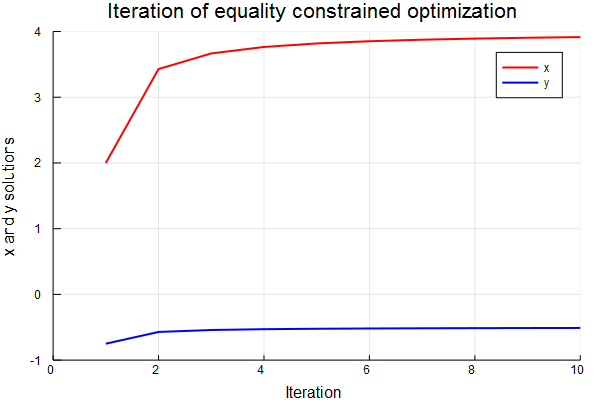

In [12]:
p1 = plot(1:10,parM[1:10,1],color=:red,linewidth=2,label="x",xlim=(0,10),ylim=(-1,4))
plot!(p1,1:10,parM[1:10,2],color=:blue,linewidth=2,label="y")
title!(p1,"Iteration of equality constrained optimization")
xlabel!(p1,"Iteration")
ylabel!(p1,"x and y solutions")
display("image/png",p1)

# Optimization with Inequality Constraints

We now impose the constraint that $y \le -(x-4)^2$, so $y+(x-4)^2 \le 0$ by defining

$
r = y + (x-4)^2
$,

and adding a penalty term $\rho \max(0,r)^2$ to the loss function and then iterate (higher and higher $\rho$, using the previous solution as the starting guess).

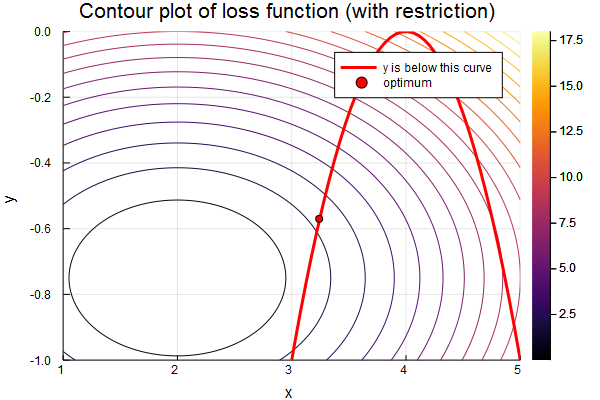

In [13]:
yRestriction = -(x.-4).^2               #y should be less than this

p1 = contour(x,y,copy(loss2d'),legend=true,levels=21) 
plot!(p1,x,yRestriction,xlims=(1,5),ylims=(-1,0),color=:red,linewidth=3,label="y is below this curve")
scatter!(p1,[3.240],[-0.570],color=:red,label="optimum")
title!(p1,"Contour plot of loss function (with restriction)")
xlabel!(p1,"x")
ylabel!(p1,"y")
display("image/png",p1)

In [14]:
function lossfun3(p::Vector,rho)
    (x,y) = (p[1],p[2])          #unpack the choice variables    
    L1 = lossfun([x;y])
    r  = y + (x-4)^2             #inequality restriction, <=
    L  = L1 + rho*max(0,r)^2
  return L
end

lossfun3 (generic function with 1 method)

In [15]:
println("\nRestricted optima")
println("iteration,        rho,  y+(x-4)^2,  x,      y")
Δpar = Inf
par0 = [4.0;-0.1]                   #initial guess obeys restriction
parMb = fill(NaN,(500,2))
i = 1
while maximum(abs.(Δpar)) > 1e-4
    global Δpar, i, par0
    local ρ, Sol, par1, x, y, r
    ρ    = (i-1)*2
    Sol  = optimize(par->lossfun3(par,ρ),par0)
    par1 = Optim.minimizer(Sol)
    (x,y) = (par1[1],par1[2])
    r    = y + (x-4)^2
    printlnPs(i,ρ,r, par1)
    parMb[i,:] = par1
    Δpar       = par1 - par0
    par0       = copy(par1)
    i          = i + 1
end


Restricted optima
iteration,        rho,  y+(x-4)^2,  x,      y
         1         0     3.250     2.000    -0.750
         2         2     0.244     2.988    -0.781
         3         4     0.136     3.041    -0.784
         4         6     0.094     3.062    -0.785
         5         8     0.072     3.073    -0.786
         6        10     0.059     3.081    -0.787
         7        12     0.049     3.085    -0.787
         8        14     0.043     3.089    -0.787
         9        16     0.038     3.092    -0.788
        10        18     0.034     3.094    -0.788
        11        20     0.030     3.096    -0.788
        12        22     0.028     3.097    -0.788
        13        24     0.025     3.098    -0.788
        14        26     0.023     3.099    -0.788
        15        28     0.022     3.100    -0.788
        16        30     0.020     3.101    -0.788
        17        32     0.019     3.101    -0.788
        18        34     0.018     3.102    -0.788
        19       

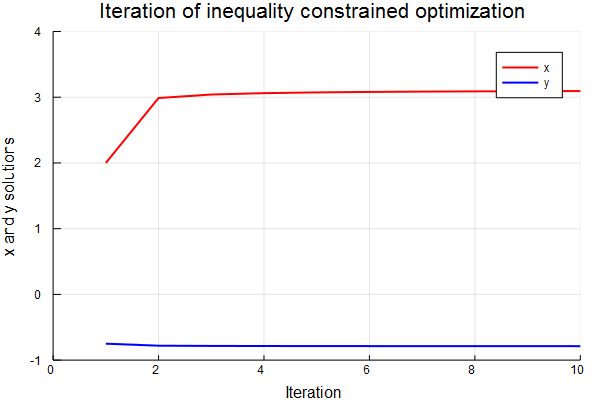

In [16]:
p1 = plot(1:10,parMb[1:10,1],color=:red,linewidth=2,label="x",xlim=(0,10),ylim=(-1,4))
plot!(p1,1:10,parMb[1:10,2],color=:blue,linewidth=2,label="y")
title!(p1,"Iteration of inequality constrained optimization")
xlabel!(p1,"Iteration")
ylabel!(p1,"x and y solutions")
display("image/png",p1)

# Optimization with Bounds on the Parameters

A simple way to handle a lower bound like $a \leq x$ is to let the optimization routine optimize with respect to a transformed variable $xb=\ln(x-a)$. Inside the loss function (and also after having obtained the minimizer) we transform back to $x$ by $x = \exp(xb) + a$.

Instead, with an upper bound $x\leq b$, we instead optimize over $xb = \ln(b-x)$ and we transform back to $x$ by $x = b- \exp(xb)$.

In the example below, we impose $2.75 \leq x$ (a lower bound) and $y \leq -0.3$ (an upper bound). We will see that only of these restrictions binds.

In [17]:
function lossfun4(p::Vector)
    (xb,yb) = (p[1],p[2])        
    x = exp(xb) + 2.75                       #transform to x
    y = -0.3 - exp(yb)                       #transform to y
    L = lossfun([x;y])
  return L
end

lossfun4 (generic function with 1 method)

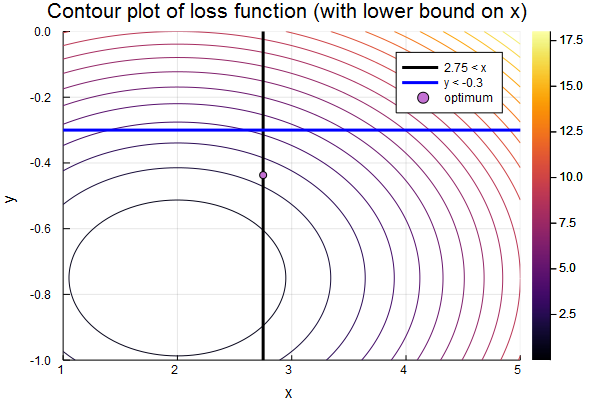

In [18]:
p1 = contour(x,y,copy(loss2d'),xlims=(1,5),ylims=(-1,0),legend=true,levels=21) 
plot!(p1,[2.75,2.75],[-1,0.5],color=:black,linewidth=3,label="2.75 < x")
plot!(p1,[1,5],[-0.3,-0.3],color=:blue,linewidth=3,label="y < -0.3")
scatter!(p1,[2.75],[-0.437],label="optimum")
title!(p1,"Contour plot of loss function (with lower bound on x)")
xlabel!(p1,"x")
ylabel!(p1,"y")
display("image/png",p1)

In [19]:
par0 = [log(3-2.75);log(-0.3-(-0.7))]        #initial guess obeys restrictions

Sol   = optimize(par->lossfun4(par),par0)
par1b = Optim.minimizer(Sol)

par1 = [exp(par1b[1])+2.75;(-0.3-exp(par1b[2]))]     #transform par1b to x and y

printlnPs("The optimin is at (x,y)= ",par1)

The optimin is at (x,y)=      2.750    -0.750
